In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler, Normalizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Functions
# Data Prep
def outliers(data, feature):
    
    percentile25 = data[feature].quantile(0.25)
    percentile75 = data[feature].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    lower_bound = percentile25 - 1.5*iqr
    upper_bound = percentile25 + 1.5*iqr

    return data.index[(data[feature] > upper_bound) | (data[feature] < lower_bound)]

def remove(data, idx_list):
    
    idx_list = sorted(set(idx_list))
    data = data.drop(idx_list)
    
    return data

# Datavis
def show_number_on_plot(ax):
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height() + p.get_height()/80))

In [3]:
# configs
data_path = '../02_data/processed/00_pre_modeling_analysis.csv'
save_data_path = '../02_data/processed/01_customer_cluster.csv'

In [4]:
df = pd.read_csv(data_path)
df_aux = deepcopy(df.drop(['Dt_Customer'], axis=1))

In [5]:
# Eliminating categorical categorical columns
categorical_columns = ['Response',
                       'Complain',
                       'AcceptedCmp1',             
                       'AcceptedCmp2',             
                       'AcceptedCmp3',            
                       'AcceptedCmp4',             
                       'AcceptedCmp5',
                       'Education',
                       'Marital_Status',
                       'accepted_cmp_before']

df_aux = df_aux[list(set(list(df_aux.columns)) - set(categorical_columns))]
df_aux.head()

,MntFishProducts,MntFruits,NumDealsPurchases,qtd_cmp_accepted,MntGoldProds,MntMeatProducts,MntSweetProducts,NumWebVisitsMonth,Recency,NumCatalogPurchases,NumStorePurchases,YearsOfEnrollment,NumWebPurchases,MntWines,Age,Kidhome,Income,Teenhome
0,172,88,3,0,88,546,88,7,58,10,4,2,8,635,55,0,58138.0,0
1,2,1,2,0,6,6,1,5,38,1,2,0,1,11,60,1,46344.0,1
2,111,49,1,0,42,127,21,4,26,2,10,1,8,426,48,0,71613.0,0
3,10,4,2,0,5,20,3,6,26,0,4,0,2,11,30,1,26646.0,0
4,46,43,5,0,15,118,27,5,94,3,6,0,5,173,33,1,58293.0,0


In [6]:
df_aux.dtypes

MntFishProducts          int64
MntFruits                int64
NumDealsPurchases        int64
qtd_cmp_accepted         int64
MntGoldProds             int64
MntMeatProducts          int64
MntSweetProducts         int64
NumWebVisitsMonth        int64
Recency                  int64
NumCatalogPurchases      int64
NumStorePurchases        int64
YearsOfEnrollment        int64
NumWebPurchases          int64
MntWines                 int64
Age                      int64
Kidhome                  int64
Income                 float64
Teenhome                 int64
dtype: object

In [7]:
df_aux = df_aux[['MntGoldProds','Age', 'YearsOfEnrollment', 'Recency', 'NumStorePurchases',
                 'Kidhome', 'Teenhome', 'NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases']]

In [8]:
# Generating normalized data
df_aux = df_aux.values

scaler = Normalizer().fit(df_aux)
df_aux = scaler.transform(df_aux)

pca = PCA(n_components=2).fit_transform(df_aux)

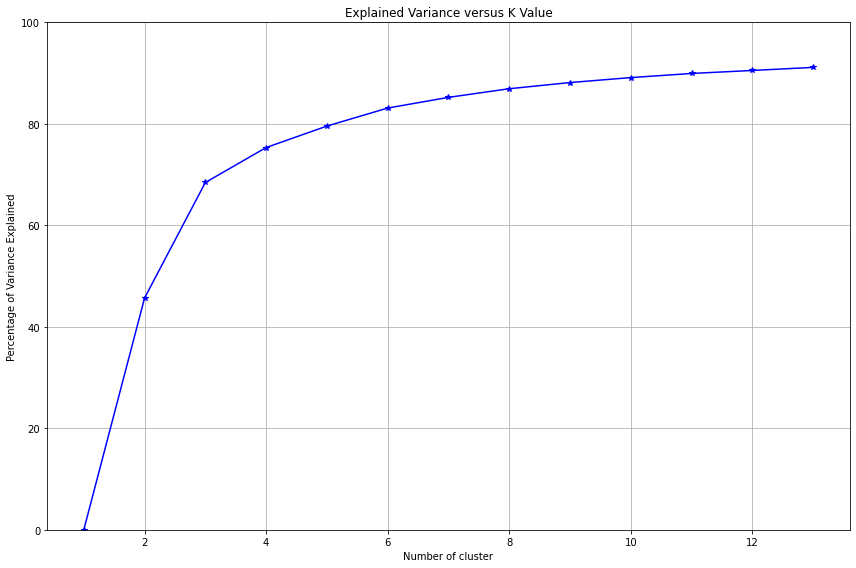

In [9]:
# Plot Size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

# K range
k_range = range(1, 14)

# Applying the K-Means model to each value of K (this cell can take a long time to run)
k_means_var = [KMeans(n_clusters = k).fit(df_aux) for k in k_range]

# Tuning the cluster centroid for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculating the Euclidean distance from each data point to the centroid
k_euclid = [cdist(df_aux, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Sum of the squares of the distances within the cluster
sum_square_intra_cluster = [sum(d**2) for d in dist]

# total sum of squares
total_sum = sum(pdist(df_aux)**2)/df_aux.shape[0]

# total sum of squares
sum_square_inter_cluster = total_sum - sum_square_intra_cluster

# Results Plot
plt.plot(k_range, sum_square_inter_cluster/total_sum * 100, 'b*-')
ax = plt.gca()
ax.set_ylim([0,100])
plt.grid(True)
plt.xlabel('Number of cluster')
plt.ylabel('Percentage of Variance Explained')
plt.title('Explained Variance versus K Value')

fig.tight_layout()
plt.show()

This plot gives us an overview of the optimal K values to use, clearly K values below 5 cannot explain most of the variance between the data.

From the above, an analysis will be made to verify the optimal value of clusters so that there is no overlap of groups.

In [10]:
# Creating a model with K = 5, 6, 7, 8, 9, 10, 11 and 12
models = dict()

# Training the Models
for i in range(5,14):
    m = KMeans(n_clusters = i)
    models.update({'model_k'+str(i) : m.fit(df_aux)})
    
# Print of Results
for key in models.keys():
    labels = models[key].labels_
    print(key,": ",silhouette_score(df_aux, labels, metric = 'euclidean'))

model_k5 :  0.3728922528035305
model_k6 :  0.37115144682985013
model_k7 :  0.3515817477362851
model_k8 :  0.3544396962924709
model_k9 :  0.3428925525362636
model_k10 :  0.32837202884558975
model_k11 :  0.3298365782304964
model_k12 :  0.3209933878375826
model_k13 :  0.3066635052562553


Given the results above, the optimal number of clusters is not very clear, the metric chosen is very close, we will do the plots in 2d to get better conclusions

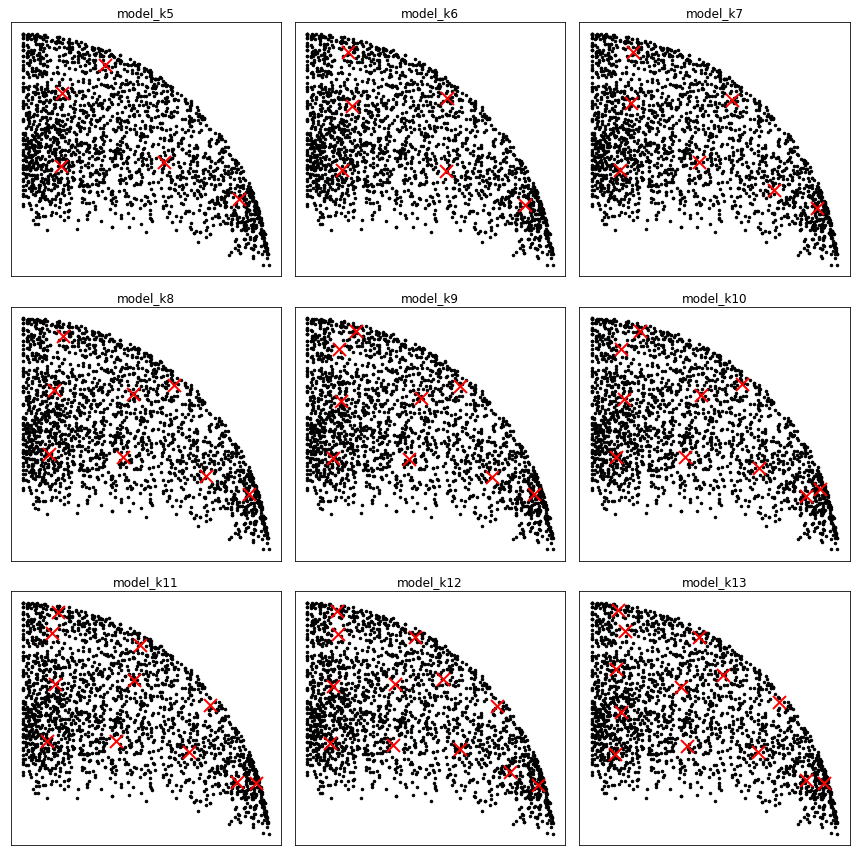

In [11]:
# Setting the size of plots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

    
# Centroids Plot
for i, model_k in enumerate(models.keys()):
    
    model = models[model_k]
    
    plt.subplot(3,3, i+1)
    plt.plot(df_aux[:, 0], df_aux[:, 1], 'k.', markersize = 5)
    centroids = model.cluster_centers_
    inert = model.inertia_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 2, color = 'r', zorder = 8)
    plt.title(model_k)
    plt.xticks(())
    plt.yticks(())


fig.tight_layout()
plt.show()

Lets plot cluster points with difertent colors to see overlapping effects

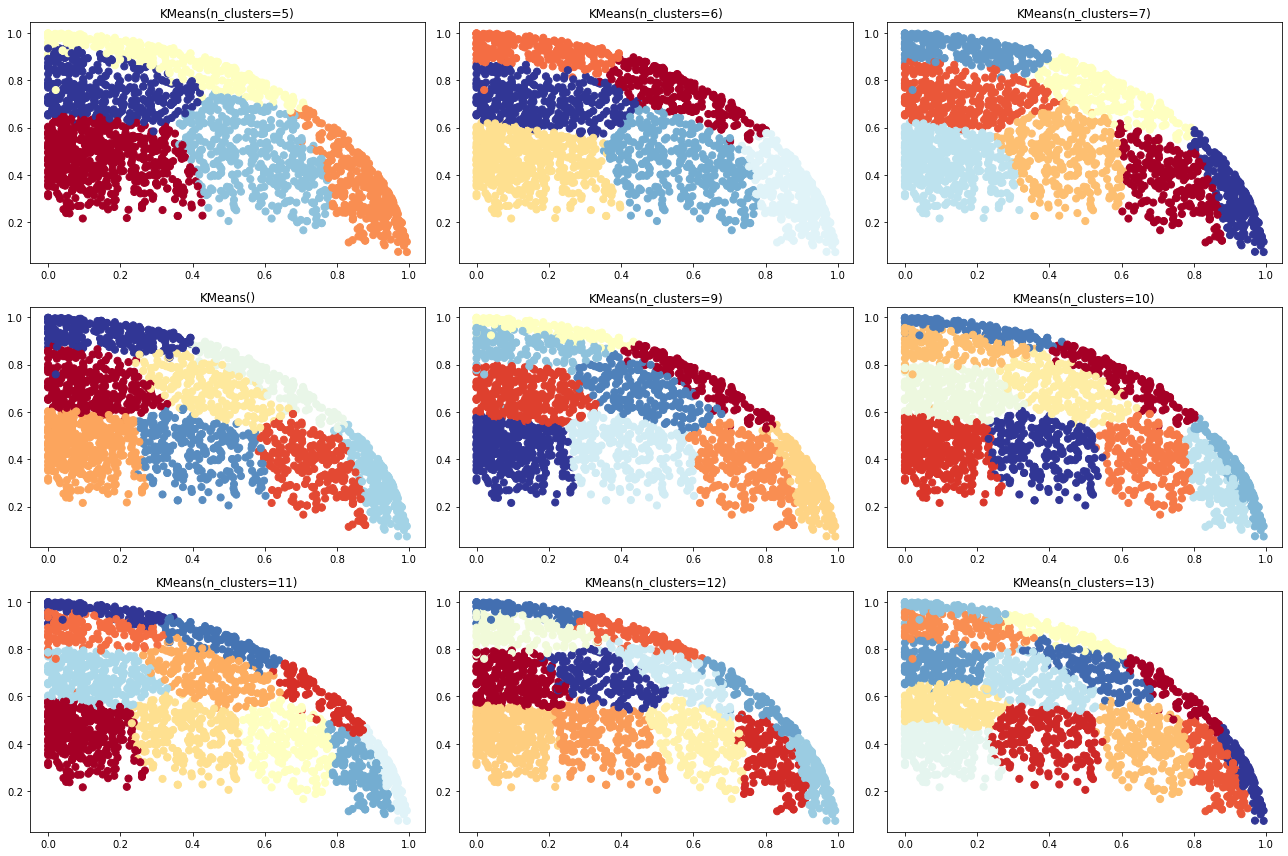

In [12]:
# Plot Gruops
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)

for i, model_k in enumerate(models.keys()):
    
    model = models[model_k]
    label = model.labels_
    
    plt.subplot(3,3,i+1)
    plt.scatter(df_aux[:, 0], df_aux[:, 1], c=label, s=50, cmap='RdYlBu')
    plt.title(model)
    
fig.tight_layout()    
plt.show()

there doesn't seem to be a strong overlap between clusters, let's keep 6 cluster since the silouette score is very close to 5 and we have one more cluster

In [36]:
model = models['model_k6']
df['Cluster'] = model.labels_ + 1

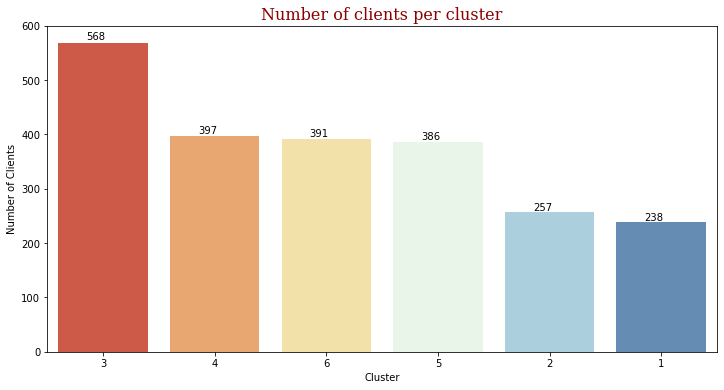

In [45]:
# Count plots 
# Plot os Gruops
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.countplot(x = 'Cluster', data = df, 
                   order = df['Cluster'].value_counts().index,
                   palette = 'RdYlBu')
plt.title('Number of clients per cluster', fontdict={'family': 'serif',
                                                    'color':  'darkred',
                                                    'weight': 'normal',
                                                    'size': 16})
plt.ylabel('Number of Clients')
plt.ylim(0,600)

show_number_on_plot(ax)
    
plt.show()

The clusters are not very unbalanced.

Let's create a supervised classification model to classify new customers.

In [49]:
!pip install scikit-learn

In [80]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [74]:
# Data type fixing
df_aux = deepcopy(df.drop('Dt_Customer', axis=1))

for col in categorical_columns:
    
    df_aux[col] = df_aux[col].astype('category')
    df_aux[col] = df_aux[col].cat.codes

In [75]:
# Feature Selection

array = df_aux.values

# creating input and output arrays
X = array[:,:28]
Y = array[:,28]

# Creating feature selection model
modelo = ExtraTreesClassifier()
modelo.fit(X, Y)

# Print Results
res = [[round(modelo.feature_importances_[i],4),df_aux.columns[i]] for i in range(len(df_aux.columns)-1)]
res.sort(); res

[[0.002, 'AcceptedCmp2'],
 [0.002, 'Complain'],
 [0.0034, 'AcceptedCmp1'],
 [0.0036, 'accepted_cmp_before'],
 [0.0052, 'AcceptedCmp5'],
 [0.0064, 'AcceptedCmp4'],
 [0.0065, 'AcceptedCmp3'],
 [0.011, 'qtd_cmp_accepted'],
 [0.0118, 'Response'],
 [0.0174, 'Kidhome'],
 [0.02, 'Teenhome'],
 [0.0232, 'YearsOfEnrollment'],
 [0.0248, 'NumDealsPurchases'],
 [0.0252, 'Marital_Status'],
 [0.0266, 'Education'],
 [0.0276, 'NumWebVisitsMonth'],
 [0.0295, 'Income'],
 [0.0335, 'NumWebPurchases'],
 [0.0353, 'NumStorePurchases'],
 [0.0356, 'MntSweetProducts'],
 [0.0357, 'NumCatalogPurchases'],
 [0.037, 'MntMeatProducts'],
 [0.0371, 'MntFruits'],
 [0.0381, 'MntFishProducts'],
 [0.0398, 'MntWines'],
 [0.0528, 'Age'],
 [0.1891, 'MntGoldProds'],
 [0.2197, 'Recency']]

In [76]:
# let's filter features with importance above 0.03
informative_features = [x[1] for x in res if x[0] >= 0.03]

In [81]:
## Testing various models

# Preparing a list of models
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))

# Setting the values for the number of folds
num_folds = 10
seed = 5

# Evaluating each model in a loop
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %4f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LDA: 0.816290 (0.029247)
NB: 0.704522 (0.034408)
KNN: 0.311575 (0.022200)
DTC: 0.916854 (0.017771)
SVM: 0.325446 (0.030401)
RFC: 0.904326 (0.021874)
